# Experiment Tracking and Model Management

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

<!-- Place this tag where you want the button to render. -->
<a class="github-button" href="https://github.com/particle1331/steepest-ascent" data-color-scheme="no-preference: dark; light: light; dark: dark;" data-icon="octicon-star" data-size="large" data-show-count="true" aria-label="Star particle1331/steepest-ascent on GitHub">Star</a>
<!-- Place this tag in your head or just before your close body tag. -->
<script async defer src="https://buttons.github.io/buttons.js"></script> 


In this module, we will look **experiment tracking** and **model management**. A machine learning experiment is defined as a session or process of making machine learning models. Experiment tracking is the process of keeping track of all relevant information in an experiments. This includes source code, environment, data, models, hyperparameters, and so on which are important for reproducing the experiment as well as for making actual predictions. 

From experience, we know that manual tracking, e.g. with spreadsheets, is error prone, not standardized, has low visibility, and difficult for teams to collaborate over. As an alternative, we will experiment tracking platforms such as [MLFlow](https://mlflow.org/). MLFlow has four main components: tracking, models, model registry, and projects. In this course, we only be cover the first three. 

```{margin}
⚠️ **Attribution:** These are notes for [Module 2](https://github.com/DataTalksClub/mlops-zoomcamp/tree/main/02-experiment-tracking) of the [MLOps Zoomcamp](https://github.com/DataTalksClub/mlops-zoomcamp). The MLOps Zoomcamp is a free course from [DataTalks.Club](https://github.com/DataTalksClub).
```

As we have seen with our previous prototyping, having the ability to reproduce results is important since we want to have the same results when deploying the model in different environments. Using experiment tracking and model management platforms allows us to have better chance at reproducing our results, as well as aid in organization (staging and deploying models) and optimization (finding the best models). 

## Getting started with MLFlow

Running the MLFlow UI with an SQLite backend:


```bash
$ mlflow ui --backend-store-uri sqlite:///mlflow.db

[2022-05-26 19:35:22 +0800] [92498] [INFO] Starting gunicorn 20.1.0
[2022-05-26 19:35:22 +0800] [92498] [INFO] Listening at: http://127.0.0.1:5000 (92498)
[2022-05-26 19:35:22 +0800] [92498] [INFO] Using worker: sync
[2022-05-26 19:35:22 +0800] [92499] [INFO] Booting worker with pid: 92499
```

For our experiment, we will use the same task and workflow from [Module 1](https://particle1331.github.io/inefficient-networks/notebooks/mlops/1-intro.html):

In [21]:
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
import matplotlib.pyplot as plt

from toolz import compose
from functools import partial

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error

import warnings
from pandas.core.common import SettingWithCopyWarning
from matplotlib_inline import backend_inline
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
backend_inline.set_matplotlib_formats('svg')


def add_pickup_dropoff_pair(df):
    """Add product of pickup and dropoff locations."""
    
    df['PU_DO'] = df['PULocationID'].astype(str) + '_' + df['DOLocationID'].astype(str)
    return df


def preprocess_dataset(filename, transforms, categorical, numerical):
    """Return processed features dict and target."""
    
    # Load dataset
    df = pd.read_parquet(filename)

    # Add target column; filter outliers
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df['duration'] = df.duration.dt.total_seconds() / 60
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    # Apply in-between transformations
    df = compose(*transforms[::-1])(df)

    # For dict vectorizer: int = ignored, str = one-hot
    df[categorical] = df[categorical].astype(str)

    # Convert dataframe to feature dictionaries
    feature_dicts = df[categorical + numerical].to_dict(orient='records')
    target = df.duration.values

    return feature_dicts, target


def plot_duration_distribution(model, X_train, y_train, X_valid, y_valid):
    """Plot true and prediction distribution."""
    
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))

    sns.histplot(model.predict(X_train), ax=ax[0], label='pred', color='C0', stat='density', kde=True)
    sns.histplot(y_train, ax=ax[0], label='true', color='C1', stat='density', kde=True)
    ax[0].set_title("Train")
    ax[0].legend();

    sns.histplot(model.predict(X_valid), ax=ax[1], label='pred', color='C0', stat='density', kde=True)
    sns.histplot(y_valid, ax=ax[1], label='true', color='C1', stat='density', kde=True)
    ax[1].set_title("Valid")
    ax[1].legend();

    fig.tight_layout()
    return fig

Setting up the experiment:

In [22]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

This creates an experiment in the UI. Recall that for our previous experiment, we could have used different models with different hyperparameters. To track this in MLFlow:

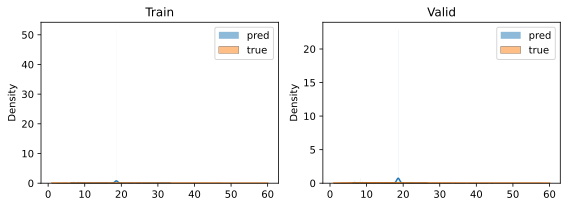

In [28]:
with mlflow.start_run():

    train_data_path = './data/green_tripdata_2021-01.parquet'
    valid_data_path = './data/green_tripdata_2021-02.parquet'
    alpha = 0.01

    # In-between transformations
    transforms = [add_pickup_dropoff_pair]
    categorical = ['PU_DO']
    numerical = ['trip_distance']

    train_dicts, y_train = preprocess_dataset(train_data_path, transforms, categorical, numerical)
    valid_dicts, y_valid = preprocess_dataset(valid_data_path, transforms, categorical, numerical)

    # Fit all possible categories
    dv = DictVectorizer()
    dv.fit(train_dicts + valid_dicts)

    X_train = dv.transform(train_dicts)
    X_valid = dv.transform(valid_dicts)

    # Train model
    lr = Lasso(alpha)
    lr.fit(X_train, y_train);

    # Plot predictions vs ground truth
    fig = plot_duration_distribution(lr, X_train, y_train, X_valid, y_valid)
    fig.savefig('models/plot.svg');

    # Print metric
    rmse_train = mean_squared_error(y_train, lr.predict(X_train), squared=False)
    rmse_valid = mean_squared_error(y_valid, lr.predict(X_valid), squared=False)

    # MLFlow logging
    mlflow.set_tag("author", "particle")
    mlflow.log_param('train_data_path', train_data_path)
    mlflow.log_param('valid_data_path', valid_data_path)
    mlflow.log_param('alpha', alpha)
    mlflow.log_metric('rmse_train', rmse_train)
    mlflow.log_metric('rmse_valid', rmse_valid)
    mlflow.log_artifact('models/plot.svg')